#  Tesla Stock Prediction with Sentiment Analysis

본 프로젝트는 테슬라(Tesla)의 주가 예측을 위해 뉴스 데이터를 기반으로 감성 분석(sentiment analysis)을 수행하고,  
이를 활용한 시계열 예측 모델(LSTM)을 통해 주가 흐름을 분석하는 데이터 기반 투자 인사이트 프로젝트입니다.

---

## 🔍 목적
- 뉴스 헤드라인을 통해 투자 심리를 정량화하고,
- 다양한 감성 분석 모델(VADER, FinBERT, OpenAI GPT, KR-FinBert)의 비교를 통해,
- 실제 주가와 감성 점수 간의 관계를 분석하며,
- LSTM을 통해 향후 주가 예측 가능성을 탐색합니다.

---

## 🧰 사용한 기술
- 감성 분석: VADER, FinBERT, OpenAI GPT, KR-FinBert
- 시계열 예측: LSTM (TensorFlow 기반)
- 시각화 및 분석: matplotlib, seaborn, pandas

# I. 주가 예측 기반 모델링

## 1. 데이터 수집 및 피처 엔지니어링

In [145]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 테슬라(TSLA) 주가 데이터 가져오기
ticker = "TSLA"
df = yf.download(ticker, start="2022-01-01", end="2025-03-22")

# 멀티인덱스를 단일 인덱스로 flatten
df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

# 기술적 지표 추가
df["MA_10"] = df["Close_TSLA"].rolling(window=10).mean()  # 10일 이동평균
df["MA_50"] = df["Close_TSLA"].rolling(window=50).mean()  # 50일 이동평균
df["Volatility"] = df["Close_TSLA"].pct_change().rolling(window=10).std()  # 변동성

# MACD 계산
df["EMA_12"] = df["Close_TSLA"].ewm(span=12, adjust=False).mean()
df["EMA_26"] = df["Close_TSLA"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA_12"] - df["EMA_26"]

# 볼린저 밴드 계산
df["Rolling_STD"] = df["Close_TSLA"].rolling(window=10).std()  # 표준편차 계산 후 별도 저장
df["Upper_Band"] = df["MA_10"] + (df["Rolling_STD"].values.flatten() * 2)
df["Lower_Band"] = df["MA_10"] - (df["Rolling_STD"].values.flatten() * 2)

# 거래량을 로그 스케일로 변환
df["Volume_log"] = np.log(df["Volume_TSLA"] + 1)

# 결측값 제거
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


## 2. Random Forest & XGBoost 예측

In [146]:
df.head()

,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,MA_10,MA_50,Volatility,EMA_12,EMA_26,MACD,Rolling_STD,Upper_Band,Lower_Band,Volume_log
Date,,,,,,,,,,,,,,,
2022-03-15,267.296661,268.523346,252.190002,258.423340,66841200,274.910995,306.759197,0.037486,274.018095,285.341794,-11.323699,11.106602,297.124199,252.697792,18.017830
2022-03-16,280.076660,280.666656,267.420013,269.666656,84028800,273.588995,304.362197,0.040730,274.950182,284.951784,-10.001602,9.317748,292.224492,254.953498,18.246670
2022-03-17,290.533325,291.666656,275.239990,276.996674,66582900,274.665994,302.508930,0.039640,277.347589,285.365232,-8.017643,10.639405,295.944805,253.387184,18.013958
2022-03-18,301.796661,302.616669,289.130005,291.496674,100414200,276.902661,301.290730,0.040994,281.108985,286.582375,-5.473390,13.671231,304.245124,249.560198,18.424814
2022-03-21,307.053345,314.283325,302.363342,304.993347,81981600,280.788663,300.333797,0.037268,285.100425,288.098743,-2.998318,16.208106,313.204875,248.372451,18.222005


📌 Random Forest 성능 평가:
  - MAE: 30.15
  - RMSE: 42.27
  - R² Score: 0.7116
----------------------------------------
📌 XGBoost 성능 평가:
  - MAE: 34.74
  - RMSE: 51.85
  - R² Score: 0.5662
----------------------------------------


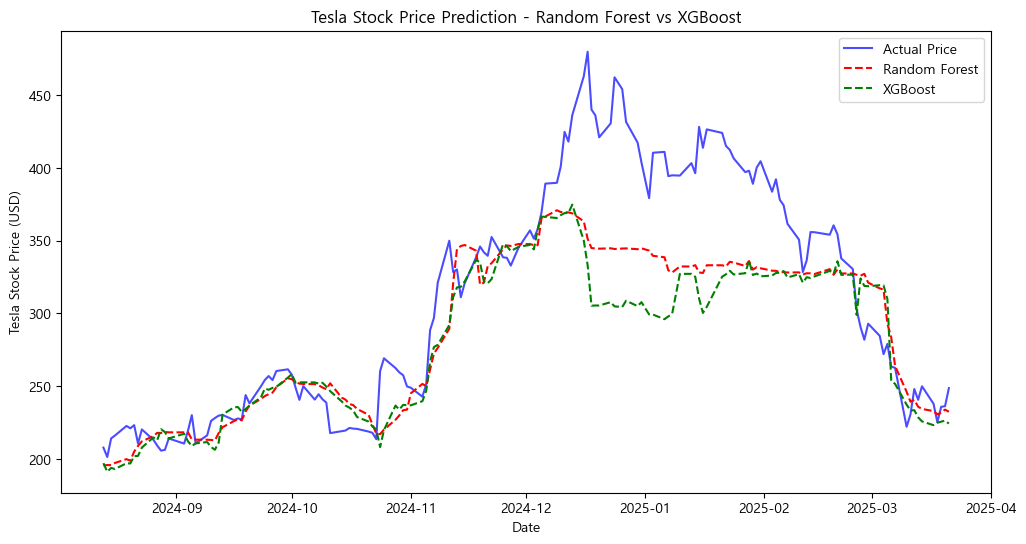

<Figure size 640x480 with 0 Axes>

In [131]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# 특성 선택
features = ["MA_10", "MA_50", "Volatility", "MACD", "Upper_Band", "Lower_Band", "Volume_log"]
X = df[features]
y = df["Close_TSLA"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 📌 랜덤 포레스트 모델
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10, min_samples_split=5 )
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 📌 XGBoost 모델
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# # 📌 성능 평가
# def evaluate_model(y_true, y_pred, model_name):
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     r2 = r2_score(y_true, y_pred)
#     print(f"📌 {model_name} RMSE: {rmse:.2f}, R² Score: {r2:.4f}")

# evaluate_model(y_test, rf_pred, "Random Forest")
# evaluate_model(y_test, xgb_pred, "XGBoost")

# 📌 성능 평가 함수 수정 (MAE 추가)
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"📌 {model_name} 성능 평가:")
    print(f"  - MAE: {mae:.2f}")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R² Score: {r2:.4f}")
    print("-" * 40)
    
    return mae, rmse, r2

# 📌 Random Forest 평가
mae_rf, rmse_rf, r2_rf = evaluate_model(y_test, rf_pred, "Random Forest")

# 📌 XGBoost 평가
mae_xgb, rmse_xgb, r2_xgb = evaluate_model(y_test, xgb_pred, "XGBoost")

# 📌 예측 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Price", color="blue", alpha=0.7)
plt.plot(y_test.index, rf_pred, label="Random Forest", color="red", linestyle="dashed")
plt.plot(y_test.index, xgb_pred, label="XGBoost", color="green", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Tesla Stock Price (USD)")
plt.title("Tesla Stock Price Prediction - Random Forest vs XGBoost")
plt.legend()
plt.show()

# 이미지 저장
plt.savefig('./results/Tesla_Stock_Price_Prediction-RandomForest_vs_XGBoost.png', dpi=300)

## 3. LSTM 기반 시계열 예측

C:\Users\naeun\Miniconda3\envs\stock\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                       │ (None, 10, 50)              │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,851 (124.42 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0245 - val_loss: 0.0155
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0090
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0094
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0078
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0095
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0131
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0138
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0120
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0067
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0090
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_lo

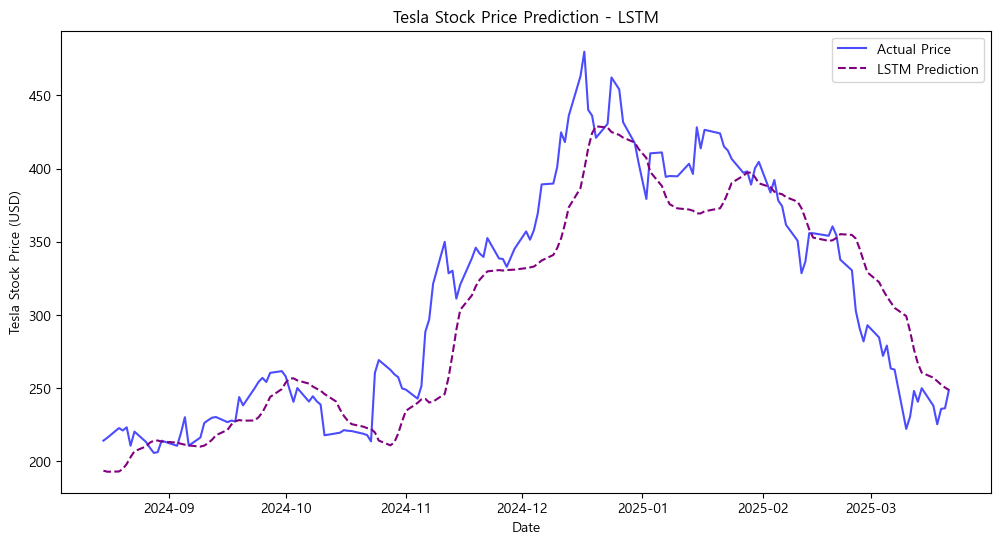

📌 MAE:  23.9187
📌 RMSE:  31.5408
📌 R2:  0.8379


<Figure size 640x480 with 0 Axes>

In [128]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 📌 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# 📌 시퀀스 데이터 생성 (LSTM 입력 형태: (samples, time steps, features))
def create_sequences(data, target, window_size):
    Xs, ys = [], []
    for i in range(len(data) - window_size):
        Xs.append(data[i : i + window_size])
        ys.append(target[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 10  # 10일 단위 시퀀스
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, window_size)

# 📌 훈련/테스트 분할
split = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# 📌 LSTM 모델 구축
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# 📌 모델 훈련
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

# 📌 예측
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# 역변환
y_test_unscaled = scaler.inverse_transform(y_test_lstm)

# 📌 LSTM 예측 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[-len(y_pred_lstm):], y_test[-len(y_pred_lstm):], label="Actual Price", color="blue", alpha=0.7)
plt.plot(y_test.index[-len(y_pred_lstm):], y_pred_lstm, label="LSTM Prediction", color="purple", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Tesla Stock Price (USD)")
plt.title("Tesla Stock Price Prediction - LSTM")
plt.legend()
plt.show()

# 이미지 저장
plt.savefig('./results/Tesla_Stock_Price_Prediction-RandomForest_vs_XGBoost.png', dpi=300)

# 평가 지표 계산
mae = mean_absolute_error(y_test_unscaled, y_pred_lstm)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_lstm))
r2 = r2_score(y_test_unscaled, y_pred_lstm)

print(f"📌 MAE: {mae: .4f}")
print(f"📌 RMSE: {rmse: .4f}")
print(f"📌 R2: {r2: .4f}")

## 4. 주식 가격과 예측 모델 성능 비교 시각화

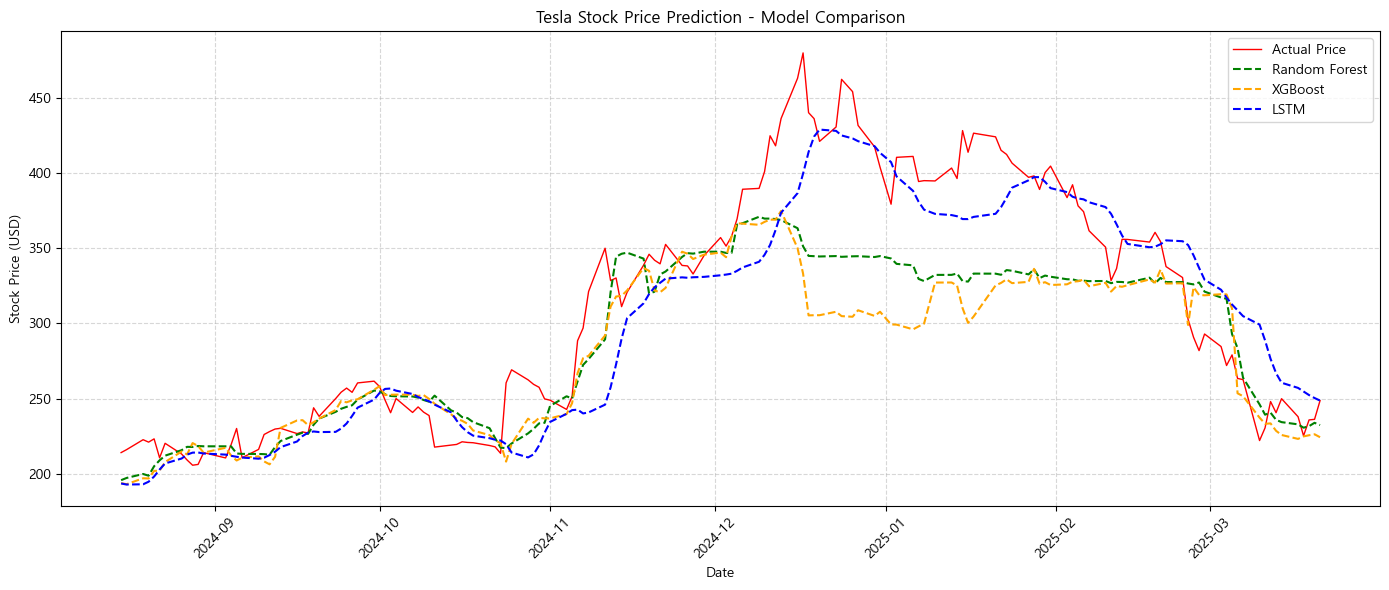

In [136]:
import matplotlib.pyplot as plt

# 예측 정렬 (LSTM은 이미 역변환 완료됨)
rf_pred = np.array(rf_pred)
xgb_pred = np.array(xgb_pred)
lstm_pred = y_pred_lstm.flatten()
actual = y_test_unscaled.flatten()

# 공통 인덱스 설정 (테스트 구간 날짜)
common_index = y_test.index[-len(actual):]

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(common_index, actual, label='Actual Price', color='red', linewidth=1)
plt.plot(common_index, rf_pred[-len(actual):], label='Random Forest', color='green', linestyle='--')
plt.plot(common_index, xgb_pred[-len(actual):], label='XGBoost', color='orange', linestyle='--')
plt.plot(common_index, lstm_pred, label='LSTM', color='blue', linestyle='--')

plt.title("Tesla Stock Price Prediction - Model Comparison")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 저장 (선택)
plt.savefig('./results/tesla_stock_prediction_model_comparison.png', dpi=300)
plt.show()

# II. 뉴스 감성 분석

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time

def get_naver_news(keyword, days=30, max_pages=3):
    """ 네이버 뉴스에서 특정 키워드(예: 테슬라)로 30일치 뉴스 크롤링 """
    base_url = "https://search.naver.com/search.naver"
    
    news_list = []
    today = datetime.datetime.today()
    
    for i in range(days):
        search_date = (today - datetime.timedelta(days=i)).strftime("%Y.%m.%d")
        for page in range(1, max_pages + 1):  # 페이지 수 제한
            params = {
                "where": "news",
                "query": keyword,
                "sort": "1",  # 최신순 정렬
                "start": (page - 1) * 10 + 1,  # 페이지네이션
                "ds": search_date,
                "de": search_date,
            }

            response = requests.get(base_url, params=params)
            soup = BeautifulSoup(response.text, "html.parser")
            
            # 뉴스 제목 가져오기
            news_titles = soup.select("a.news_tit")

            for title in news_titles:
                news_list.append({"date": search_date, "headline": title.text})

        time.sleep(1)  # 크롤링 예절 지키기 (서버 부하 방지)

    return pd.DataFrame(news_list)

# 🔹 뉴스 크롤링 실행 (테슬라 관련 뉴스)
df_news = get_naver_news("테슬라", days=30)
print(df_news.head())  # 뉴스 데이터 확인

         date                                    headline
0  2025.03.24   뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한... 
1  2025.03.24         이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까 
2  2025.03.24  미국 불신하는 동맹국들…"서방 공군 주축 F-35 `새로운 테슬라` 됐다" 
3  2025.03.24      [단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보 
4  2025.03.24       이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보 


## 1. 감성 분석 모델 비교 (VADER, FinBERT, KR-FinBERT)

### 🔹 방법 1: VADER (NLTK) 활용

In [10]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# 🔹 VADER 감성 분석기 다운로드 (한 번만 실행)
nltk.download("vader_lexicon")

# 🔹 VADER 감성 분석 적용
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """VADER를 사용한 감성 점수 계산"""
    sentiment_score = sia.polarity_scores(text)["compound"]
    if sentiment_score >= 0.05:
        return 1  # 긍정
    elif sentiment_score <= -0.05:
        return -1  # 부정
    else:
        return 0  # 중립

# 🔹 뉴스 데이터에 감성 점수 적용
df_news["sentiment_vader"] = df_news["headline"].apply(get_vader_sentiment)
print(df_news.head())

         date                                    headline  sentiment_vader
0  2025.03.24   뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한...                 0
1  2025.03.24         이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까                 0
2  2025.03.24  미국 불신하는 동맹국들…"서방 공군 주축 F-35 `새로운 테슬라` 됐다"                 0
3  2025.03.24      [단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보                 0
4  2025.03.24       이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보                 0


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\문옥공\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 🔹 방법 2: FinBERT 활용 (금융 뉴스에 특화된 감성 분석)

In [13]:
from transformers import pipeline

# 🔹 FinBERT 감성 분석 모델 로드
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def get_finbert_sentiment(text):
    """FinBERT를 사용한 감성 분석"""
    result = sentiment_pipeline(text)
    label = result[0]["label"]
    if label == "positive":
        return 1  # 긍정
    elif label == "negative":
        return -1  # 부정
    else:
        return 0  # 중립

# 🔹 FinBERT 감성 분석 적용
df_news["sentiment_finbert"] = df_news["headline"].apply(get_finbert_sentiment)
print(df_news.head())

Device set to use cpu


         date                                    headline  sentiment_vader   
0  2025.03.24   뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한...                 0  \
1  2025.03.24         이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까                 0   
2  2025.03.24  미국 불신하는 동맹국들…"서방 공군 주축 F-35 `새로운 테슬라` 됐다"                 0   
3  2025.03.24      [단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보                 0   
4  2025.03.24       이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보                 0   

   sentiment_finbert  
0                  0  
1                  0  
2                  1  
3                  0  
4                  0  


In [8]:
df_news["sentiment"] = (df_news["sentiment_vader"] + df_news["sentiment_finbert"]) / 2

##  2. OpenAI 기반 감성 점수 추출

### 1️⃣ OpenAI API를 활용한 뉴스 감성 분석

In [20]:
import openai
import pandas as pd
from dotenv import load_dotenv
import os
from tqdm import tqdm

# .env 파일에서 환경 변수 로드
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

client = openai.OpenAI()

# 프롬프트를 활용한 감성 분석 함수
def analyze_sentiment_openai(headline, company="Tesla", term="short"):
    prompt = f"""
    Forget all your previous instructions. Pretend you are a financial expert. 
    You are a financial expert with stock recommendation experience. 
    Answer "YES" if good news, "NO" if bad news, or "UNKNOWN" if uncertain in the first line. 
    Then elaborate with one short and concise sentence on the next line. 
    Is this headline good or bad for the stock price of {company} in the {term} term? 

    Headline: {headline}
    """

    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    temperature=0  # 재현성을 위해 Temperature를 0으로 설정
)

    result = response.choices[0].message.content
    return result

# 참고: 이 분석에서는 헤드라인이 주가에 영향을 주는 정보를 충분히 담고 있다고 가정합니다.
# 또한 GPT의 결과 재현성을 높이기 위해 temperature 값을 0으로 설정하였습니다.

# OpenAI 감성 분석 적용
df_news["sentiment_openai"] = df_news["headline"].apply(lambda x: analyze_sentiment_openai(x))

# 결과 출력
print(df_news)

           date                                         headline   
0    2025.03.24        뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한...   \
1    2025.03.24              이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까    
2    2025.03.24       미국 불신하는 동맹국들…"서방 공군 주축 F-35 `새로운 테슬라` 됐다"    
3    2025.03.24           [단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보    
4    2025.03.24            이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보    
..          ...                                              ...   
441  2025.02.24            이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보    
442  2025.02.24  SK시그넷, V2 충전기 미국 사용자 만족도 9.5점 기록 … "품질 혁신으로...    
443  2025.02.24               테슬라 모델 Y 신형 주니퍼 초기물량 60대, 평택항에 도착    
444  2025.02.24    뉴욕증시 프리뷰, 미 주가지수 선물 '바닥 확인' 기대 속 반등...테슬라...    
445  2025.02.24               이재용, 샤오미 이어 BYD 본사 방문…車 전장사업 힘 싣나    

     sentiment_vader  sentiment_finbert   
0                  0                  0  \
1                  0                  0   
2                  0                  1   
3          

In [21]:
import pandas as pd

# sentiment_openai 텍스트를 점수로 바꾸는 함수
def map_sentiment_openai(text):
    first_line = text.strip().split('\n')[0]
    sentiment_dict = {'YES': 1, 'NO': -1, 'UNKNOWN': 0}
    return sentiment_dict.get(first_line.strip(), 0)

# 위의 함수를 적용하여 수치로 변환
df_news['sentiment_openai_score'] = df_news['sentiment_openai'].apply(map_sentiment_openai)

# 변환 결과 확인
print(df_news[['date', 'headline', 'sentiment_openai', 'sentiment_openai_score']].head())

         date                                    headline   
0  2025.03.24   뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한...   \
1  2025.03.24         이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까    
2  2025.03.24  미국 불신하는 동맹국들…"서방 공군 주축 F-35 `새로운 테슬라` 됐다"    
3  2025.03.24      [단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보    
4  2025.03.24       이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보    

                                    sentiment_openai  sentiment_openai_score  
0  UNKNOWN  \nThe headline does not provide clear...                       0  
1  UNKNOWN  \nThe headline suggests potential col...                       0  
2  UNKNOWN  \nThe headline suggests a shift in mi...                       0  
3  UNKNOWN  \nThe headline suggests potential com...                       0  
4  UNKNOWN  \nThe headline indicates a visit to B...                       0  


In [22]:
df_news.loc[:, ['date', 'headline', 'sentiment_openai', 'sentiment_openai_score']].drop_duplicates(subset='headline')

,date,headline,sentiment_openai,sentiment_openai_score
0,2025.03.24,"뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한...",UNKNOWN \nThe headline does not provide clear...,0
1,2025.03.24,"이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까",UNKNOWN \nThe headline suggests potential col...,0
2,2025.03.24,"미국 불신하는 동맹국들…""서방 공군 주축 F-35 `새로운 테슬라` 됐다""",UNKNOWN \nThe headline suggests a shift in mi...,0
3,2025.03.24,"[단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보",UNKNOWN \nThe headline suggests potential com...,0
4,2025.03.24,"이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보",UNKNOWN \nThe headline indicates a visit to B...,0
5,2025.03.24,"SK시그넷, V2 충전기 미국 사용자 만족도 9.5점 기록 … ""품질 혁신으로...",UNKNOWN \nThe headline discusses user satisfa...,0
6,2025.03.24,"테슬라 모델 Y 신형 주니퍼 초기물량 60대, 평택항에 도착",YES \nThe arrival of initial units of the new...,1
7,2025.03.24,"뉴욕증시 프리뷰, 미 주가지수 선물 '바닥 확인' 기대 속 반등...테슬라...",YES \nThe expectation of a rebound in U.S. st...,1
8,2025.03.24,"이재용, 샤오미 이어 BYD 본사 방문…車 전장사업 힘 싣나",UNKNOWN \nThe headline suggests potential col...,0
9,2025.03.24,"이재용, 中 비야디 방문...'전장' 확대 포석",UNKNOWN \nThe headline suggests potential str...,0


### 2️⃣ Fin-BERT

FinBERT는 금융 도메인에 특화된 BERT 모델이며, 특히 금융 뉴스와 관련된 텍스트의 감성 분석에 좋은 성능을 보입니다. 
하지만 영어 모델이라 한국어 텍스트에는 성능이 떨어질 수 있습니다.

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# FinBERT 모델 로드
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def analyze_sentiment_finbert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment_idx = probabilities.argmax(dim=1).item()
        sentiment_score = probabilities[0].tolist()
    
    # FinBERT는 negative(0), neutral(1), positive(2) 순서로 출력
    sentiment_map = {0: -1, 1: 0, 2: 1}  # 부정: -1, 중립: 0, 긍정: 1
    return sentiment_map[sentiment_idx], sentiment_score

# 데이터프레임의 모든 헤드라인에 감성 분석 적용
sentiments = []
scores_list = []

for headline in tqdm(df_news['headline'], desc="FinBERT 감성 분석 중"):
    try:
        sentiment, score = analyze_sentiment_finbert(headline)
        sentiments.append(sentiment)
        scores_list.append(score)
    except Exception as e:
        print(f"오류 발생: {headline[:30]}... - {e}")
        sentiments.append(0)  # 오류 시 중립(0)으로 처리
        scores_list.append(None)

# 결과를 데이터프레임에 추가
df_news['sentiment_finbert'] = sentiments
df_news['sentiment_finbert_score'] = scores_list

# 결과 확인
print(df_news[['headline', 'sentiment_finbert']].head())

# 감성 분포 확인
print("\n감성 분포:")
print(df_news['sentiment_finbert'].value_counts())

FinBERT 감성 분석 중: 100%|██████| 446/446 [00:38<00:00, 11.71it/s]

                                     headline  sentiment_finbert
0   뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한...                   1
1         이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까                   1
2  미국 불신하는 동맹국들…"서방 공군 주축 F-35 `새로운 테슬라` 됐다"                  -1
3      [단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보                   1
4       이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보                   1

감성 분포:
sentiment_finbert
 1    409
-1     37
Name: count, dtype: int64


In [25]:
df_news.to_csv('df_news.csv', index=False)

### 3️⃣ 한국어 BERT 모델

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.notebook import tqdm

# 금융 도메인 한국어 감성 분석 모델 사용
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC")

def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    
    with torch.no_grad():
        outputs = model(**inputs)  # SequenceClassifierOutput 객체 반환
        # outputs.logits를 직접 사용 (last_hidden_state 대신)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        sentiment_idx = probabilities.argmax(dim=1).item()
        sentiment_score = probabilities[0].tolist()
    
    # 감성 클래스를 직접 -1, 0, 1로 맵핑
    sentiment_map = {0: -1, 1: 0, 2: 1}  # 부정: -1, 중립: 0, 긍정: 1
    return sentiment_map[sentiment_idx], sentiment_score

# 데이터프레임의 모든 헤드라인에 감성 분석 적용
sentiments = []
scores_list = []

for headline in tqdm(df_news['headline'], desc="감성 분석 중"):
    try:
        sentiment, score = analyze_sentiment(headline)
        sentiments.append(sentiment)
        scores_list.append(score)
    except Exception as e:
        print(f"오류 발생: {headline[:30]}... - {e}")
        sentiments.append(0)  # 오류 시 중립(0)으로 처리
        scores_list.append(None)

# 결과를 데이터프레임에 추가
df_news['KR-FinBert'] = sentiments
df_news['KR-FinBert_score'] = scores_list

# 결과 확인
print(df_news[['headline', 'KR-FinBert']].head())

# 감성 분포 확인
print("\n감성 분포:")
print(df_news['KR-FinBert'].value_counts())

pytorch_model.bin:  36%|###6      | 147M/406M [00:00<?, ?B/s]

C:\Users\naeun\Miniconda3\envs\stock\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\문옥공\.cache\huggingface\hub\models--snunlp--KR-FinBert-SC. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


감성 분석 중:   0%|          | 0/446 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/406M [00:00<?, ?B/s]

                                     headline  KR-FinBert
0   뇌에 ‘컴퓨터칩’ 심은 남성, 충격 근황 “생각만해도 된다…불가능한...            0
1         이재용, 中 샤오미 이어 BYD도 방문…車 전장 사업 확대할까            0
2  미국 불신하는 동맹국들…"서방 공군 주축 F-35 `새로운 테슬라` 됐다"            0
3      [단독] 이재용, BYD 선전 본사 방문…샤오미 이어 中 광폭 행보            1
4       이재용, 中 샤오미 이어 BYD 본사 방문…車 전장사업 확대 행보            0

감성 분포:
KR-FinBert
 0    281
 1    133
-1     32
Name: count, dtype: int64


In [143]:
df_news.loc[20:,['date', 'headline', 'sentiment_vader', 'sentiment_finbert', 'sentiment', 'sentiment_openai_score', 'KR-FinBert']]

,date,headline,sentiment_vader,sentiment_finbert,sentiment,sentiment_openai_score,KR-FinBert
20,2025-03-12,"루마니아 '푸틴 칭송' 극우 대선 후보 출마 금지...머스크 ""미친 짓""",0,0,0.0,0,0
21,2025-03-12,"돌아온 外人, 코스피 '급등'...하나금융·SK하이닉스 '껑충'",0,-1,-0.5,0,0
22,2025-03-12,'KODEX 미국서학개미 ETF' 올해 수익률 '바닥권',0,-1,-0.5,-1,1
23,2025-03-12,"트럼프의 테슬라 vs 레이건의 할리 데이비슨, 무엇이 다른가? [데스크칼...",0,0,0.0,0,0
24,2025-03-12,한달동안 '-30%'....손절? 저가매수? 혼돈의 서학개미,0,0,0.0,-1,0
...,...,...,...,...,...,...,...
895,2025-02-11,"머스크와 '모델S' 시승 트럼프…""테슬라 공격시 '테러'로 처벌""(종합2보...",0,-1,-0.5,-1,0
896,2025-02-11,"테슬라 유럽 판매 급감 이유, 신차 출시 위해 모델 Y 생산 중단이 주요...",0,0,0.0,-1,-1
897,2025-02-11,"`자산운용` 키우는 우리금융, 美부자 꿈꾸며 `EMP펀드` 출시",0,-1,-0.5,0,1
898,2025-02-11,"현대차 모셔널 테슬라·구글 뒤따른다, 자율주행 기술 '엔드투엔드'로 ...",0,-1,-0.5,0,1


In [81]:
print(df_news['sentiment'].value_counts())
print(df_news['sentiment_openai_score'].value_counts())
print(df_news['KR-FinBert'].value_counts())

sentiment
-0.5    471
 0.0    429
Name: count, dtype: int64
sentiment_openai_score
 0    485
-1    385
 1     30
Name: count, dtype: int64
KR-FinBert
 0    429
-1    261
 1    210
Name: count, dtype: int64


## 3. 감성 점수 시각화 및 주가 연동 분석

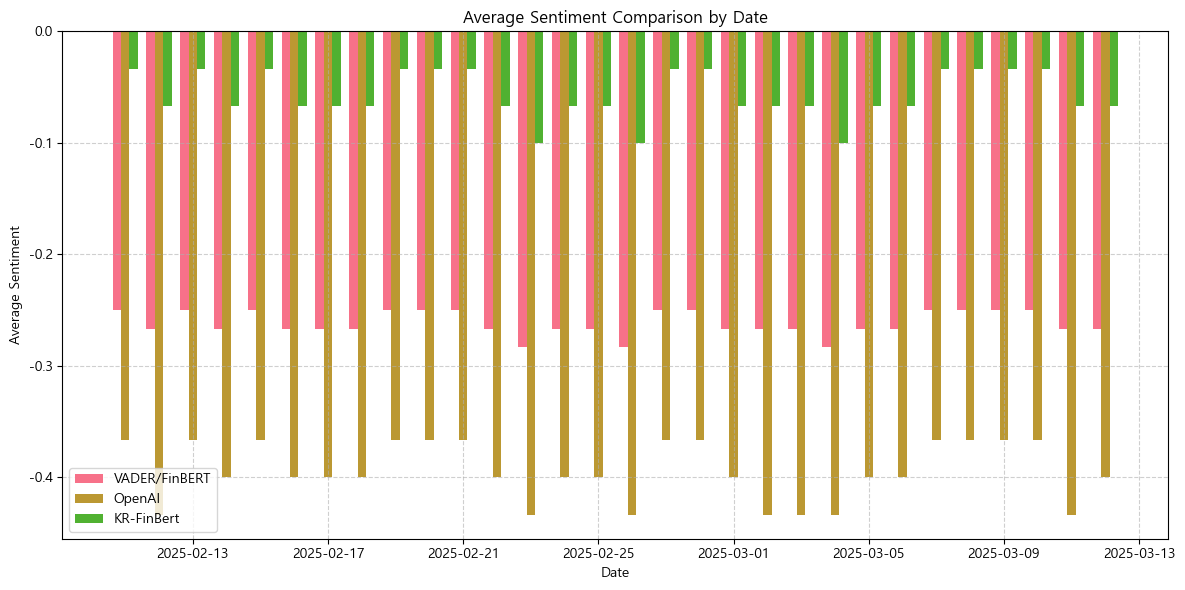

In [118]:
# 📌 1. 날짜별 감성점수 평균 비교 시각화 (Bar Plot)

import matplotlib.pyplot as plt
import pandas as pd
import os

# results 폴더 생성 (존재하지 않으면 자동 생성)
os.makedirs('./results', exist_ok=True)

# 날짜별 평균 sentiment 계산
df_news['date'] = pd.to_datetime(df_news['date'])
daily_sentiments = df_news.groupby('date').agg({
    'sentiment': 'mean',
    'sentiment_openai_score': 'mean',
    'KR-FinBert': 'mean'  # KcELECTRA 추가
}).reset_index()

# 그래프 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 약간 증가
width = 0.25  # 막대 너비 조정 (3개의 막대를 위해)

# 각 모델의 결과를 약간의 간격을 두고 표시
plt.bar(daily_sentiments['date'] - pd.Timedelta(days=width), 
        daily_sentiments['sentiment'], width=width, label='VADER/FinBERT')

plt.bar(daily_sentiments['date'], 
        daily_sentiments['sentiment_openai_score'], width=width, label='OpenAI')

plt.bar(daily_sentiments['date'] + pd.Timedelta(days=width), 
        daily_sentiments['KR-FinBert'], width=width, label='KR-FinBert')

plt.axhline(0, color='grey', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment Comparison by Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 이미지 저장
plt.savefig('./results/average_sentiment_comparison.png', dpi=300)

plt.show()

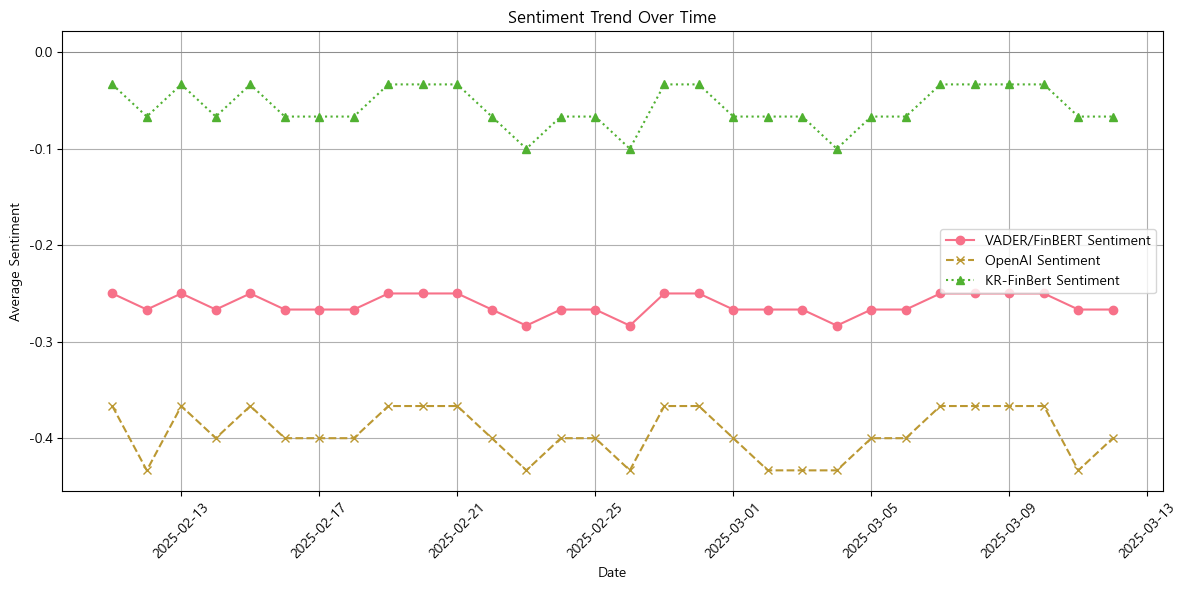

In [119]:
# 📌 2. Sentiment 점수의 시계열 추이 (Line plot)

# Sentiment 점수 시계열 추이 시각화
plt.figure(figsize=(12, 6))

# Vader/FinBERT 평균 sentiment
plt.plot(daily_sentiments['date'], daily_sentiments['sentiment'], 
         marker='o', linestyle='-', label='VADER/FinBERT Sentiment')

# OpenAI 평균 sentiment
plt.plot(daily_sentiments['date'], daily_sentiments['sentiment_openai_score'], 
         marker='x', linestyle='--', label='OpenAI Sentiment')

# KcELECTRA 평균 sentiment 추가
plt.plot(daily_sentiments['date'], daily_sentiments['KR-FinBert'], 
         marker='^', linestyle=':', label='KR-FinBert Sentiment')

plt.axhline(0, color='grey', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Trend Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 이미지 저장
plt.savefig('./results/sentiment_trend_over_time.png', dpi=300)

plt.show()

In [84]:
import yfinance as yf

# 테슬라 주식 데이터 가져오기
ticker = "TSLA"
df_stock = yf.download(ticker, start="2025-02-11", end="2025-03-12")

# 데이터 확인
print(df_stock.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-02-11  328.500000  349.369995  325.100006  345.799988  118543400
2025-02-12  336.510010  346.399994  329.119995  329.940002  105382700
2025-02-13  355.940002  358.690002  342.850006  345.000000   89441500
2025-02-14  355.839996  362.000000  347.500000  360.619995   68277300
2025-02-18  354.109985  359.100006  350.019989  355.010010   51631700


In [85]:
# 멀티인덱스에서 종가(close) 데이터 추출
df_stock_close = df_stock[('Close', 'TSLA')].reset_index()
df_stock_close.columns = ['date', 'close']

# 날짜 형식 변환
df_stock_close['date'] = pd.to_datetime(df_stock_close['date'])

In [86]:
daily_sentiments = df_news.groupby('date').agg({
    'sentiment':'mean',
    'sentiment_openai_score':'mean',
    'KR-FinBert': 'mean'
}).reset_index()

In [87]:
# 종가와 sentiment 데이터 병합
final_df = pd.merge(daily_sentiments, df_stock_close, on='date', how='inner')

print(final_df.head())

        date  sentiment  sentiment_openai_score  KR-FinBert       close
0 2025-02-11  -0.250000               -0.366667   -0.033333  328.500000
1 2025-02-12  -0.266667               -0.433333   -0.066667  336.510010
2 2025-02-13  -0.250000               -0.366667   -0.033333  355.940002
3 2025-02-14  -0.266667               -0.400000   -0.066667  355.839996
4 2025-02-18  -0.266667               -0.400000   -0.066667  354.109985


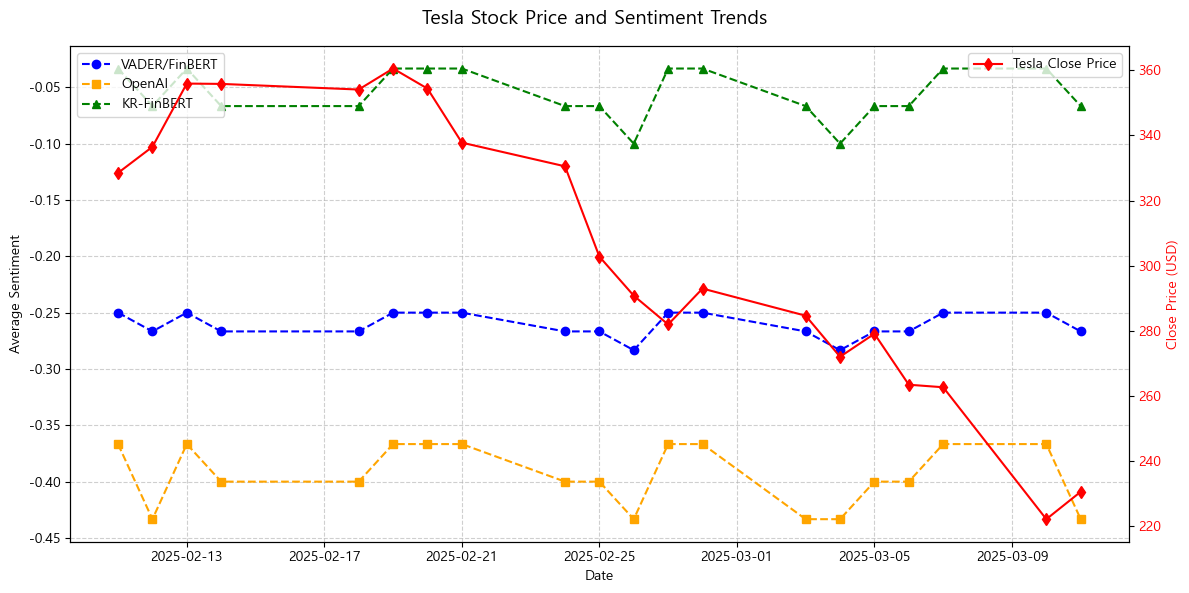

In [134]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# 감성 점수 선 (좌측 축)
ax1.plot(final_df['date'], final_df['sentiment'], 
         marker='o', linestyle='--', label='VADER/FinBERT', color='blue')
ax1.plot(final_df['date'], final_df['sentiment_openai_score'], 
         marker='s', linestyle='--', label='OpenAI', color='orange')
ax1.plot(final_df['date'], final_df['KR-FinBert'], 
         marker='^', linestyle='--', label='KR-FinBERT', color='green')

ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment')
ax1.tick_params(axis='y', labelcolor='black')

# 종가 선 (우측 축)
ax2 = ax1.twinx()
ax2.plot(final_df['date'], final_df['close'], 
         marker='d', linestyle='-', label='Tesla Close Price', color='red')
ax2.set_ylabel('Close Price (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 제목 및 범례
fig.suptitle('Tesla Stock Price and Sentiment Trends', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 스타일
ax1.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
fig.tight_layout()

# 저장
plt.savefig('./results/tesla_stock_and_sentiment_trends.png', dpi=300)
plt.show()


In [89]:
sentiments_done = df_news.loc[:, ['date', 'headline', 'sentiment_vader', 'sentiment_finbert', 'sentiment', 'sentiment_openai_score', 'KR-FinBert']]

##  4. 주식 데이터와 감성분석 데이터 병합

In [90]:
# 1. 멀티인덱스 데이터프레임을 단일 인덱스로 변환
df_stock_single = df_stock.reset_index()
df_stock_single.columns = ['Date'] + [f'{col[0]}_{col[1]}' for col in df_stock.columns]

# 2. 날짜 형식 통일
df_stock_single['Date'] = pd.to_datetime(df_stock_single['Date'])
df_news['date'] = pd.to_datetime(df_news['date'])

# 3. 데이터프레임 병합
df_merged = df_stock_single.merge(df_news, left_on='Date', right_on='date', how='left')

# 4. 불필요한 'date' 컬럼 제거
df_merged = df_merged.drop('date', axis=1)

# 결과 확인
print("\n최종 컬럼:")
print(df_merged.columns)
print("\n데이터 미리보기:")
print(df_merged.head())


최종 컬럼:
Index(['Date', 'Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA',
       'Volume_TSLA', 'headline', 'sentiment_vader', 'sentiment_finbert',
       'sentiment', 'sentiment_openai_score', 'KR-FinBert'],
      dtype='object')

데이터 미리보기:
        Date  Close_TSLA   High_TSLA    Low_TSLA   Open_TSLA  Volume_TSLA   
0 2025-02-11       328.5  349.369995  325.100006  345.799988    118543400  \
1 2025-02-11       328.5  349.369995  325.100006  345.799988    118543400   
2 2025-02-11       328.5  349.369995  325.100006  345.799988    118543400   
3 2025-02-11       328.5  349.369995  325.100006  345.799988    118543400   
4 2025-02-11       328.5  349.369995  325.100006  345.799988    118543400   

                                         headline  sentiment_vader   
0                           [필동정담] NASA국장과 구로구청장                 0  \
1     FT "트럼프, 머스크와의 결별은 시간문제···곁에 두기엔 정치적 부담...                 0   
2       트럼프, 주가 폭락한 테슬라 시승…"머스크, 1억불 기부로 화답"(종합)                 0   
3  찬 바람 속 희소식 

#  III. 감성 점수 포함 예측 모델링

In [91]:
# 🔹 감성 점수 추가한 피처 선택
features = ['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA', 'sentiment_vader', 'sentiment_finbert', 'sentiment', 'sentiment_openai_score', 'KR-FinBert']

# 🔹 학습 데이터셋 생성
X = df_merged[features]
y = df_merged['Close_TSLA'].shift(-1)  # 다음날 종가 예측

# NaN 제거 (마지막 행의 y값이 NaN이 됨)
X = X[:-1]  # 마지막 행 제외
y = y[:-1]  # 마지막 행 제외

# 데이터 확인
print("X shape:", X.shape)
print("y shape:", y.shape)

# 피처 데이터 미리보기
print("\nX 데이터 미리보기:")
print(X.head())
print("\ny 데이터 미리보기:")
print(y.head())

X shape: (599, 10)
y shape: (599,)

X 데이터 미리보기:
   Close_TSLA   High_TSLA    Low_TSLA   Open_TSLA  Volume_TSLA   
0       328.5  349.369995  325.100006  345.799988    118543400  \
1       328.5  349.369995  325.100006  345.799988    118543400   
2       328.5  349.369995  325.100006  345.799988    118543400   
3       328.5  349.369995  325.100006  345.799988    118543400   
4       328.5  349.369995  325.100006  345.799988    118543400   

   sentiment_vader  sentiment_finbert  sentiment  sentiment_openai_score   
0                0                  0        0.0                       0  \
1                0                 -1       -0.5                      -1   
2                0                 -1       -0.5                      -1   
3                0                  0        0.0                       0   
4                0                  0        0.0                       0   

   KR-FinBert  
0           0  
1           0  
2          -1  
3           0  
4           1  

y

##  XGBoost vs LSTM
### 🔹 방법 1: XGBoost Feature Set Comparison (기술적 지표 vs 감성 포함)

In [115]:
# 기본 피처와 감성 피처 정의
features_base = ['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA']
features_sentiment = ['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA', 
                     'sentiment_vader', 'sentiment_finbert', 'sentiment', 
                     'sentiment_openai_score', 'KR-FinBert']

# X 데이터 준비 (마지막 행 제외)
X_base = df_merged[features_base][:-1]  # 마지막 행 제외
X_sentiment = df_merged[features_sentiment][:-1]  # 마지막 행 제외

# y 데이터 준비 (NaN 제외)
y = df_merged['Close_TSLA'].shift(-1)[:-1]  # 마지막 행 제외

# 데이터 크기 확인
print("X_base shape:", X_base.shape)
print("X_sentiment shape:", X_sentiment.shape)
print("y shape:", y.shape)

X_base shape: (599, 5)
X_sentiment shape: (599, 10)
y shape: (599,)


In [99]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1) 기존 피처만 사용
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, 
                                                             test_size=0.2, 
                                                             random_state=42)
model_base = XGBRegressor(n_estimators=200, 
                         max_depth=5, 
                         random_state=42,
                         learning_rate=0.1)  
model_base.fit(X_train_base, y_train)
y_pred_base = model_base.predict(X_test_base)

# 📌 기존 모델 성능 계산
mae_xgb_base = mean_absolute_error(y_test, y_pred_base)
rmse_xgb_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_xgb_base = r2_score(y_test, y_pred_base)

# 2) Sentiment 추가
X_train_sentiment, X_test_sentiment, _, _ = train_test_split(X_sentiment, y, 
                                                           test_size=0.2, 
                                                           random_state=42)
model_sentiment = XGBRegressor(n_estimators=200, 
                             max_depth=5, 
                             random_state=42,
                             learning_rate=0.1)  
model_sentiment.fit(X_train_sentiment, y_train)
y_pred_sentiment = model_sentiment.predict(X_test_sentiment)

# 📌 Sentiment 추가 모델 성능 계산
mae_xgb_sentiment = mean_absolute_error(y_test, y_pred_sentiment)
rmse_xgb_sentiment = np.sqrt(mean_squared_error(y_test, y_pred_sentiment))
r2_xgb_sentiment = r2_score(y_test, y_pred_sentiment)

# 3) 결과 비교 및 시각화
print("📌 Model Performance Comparison:")
print("-" * 40)
print(f"📌 기존 모델 성능:")
print(f"  - MAE  : {mae_xgb_base:.4f}")
print(f"  - RMSE : {rmse_xgb_base:.4f}")
print(f"  - R²   : {r2_xgb_base:.4f}")
print("-" * 40)
print(f"📌 Sentiment 추가 모델 성능:")
print(f"  - MAE  : {mae_xgb_sentiment:.4f}")
print(f"  - RMSE : {rmse_xgb_sentiment:.4f}")
print(f"  - R²   : {r2_xgb_sentiment:.4f}")
print("-" * 40)

# 📌 성능 향상률 계산
mae_improvement = ((mae_xgb_base - mae_xgb_sentiment) / mae_xgb_base) * 100
rmse_improvement = ((rmse_xgb_base - rmse_xgb_sentiment) / rmse_xgb_base) * 100
print(f"📌 성능 향상률 (MAE 기준): {mae_improvement:.2f}%")
print(f"📌 성능 향상률 (RMSE 기준): {rmse_improvement:.2f}%")
print("-" * 40)

# 피처 중요도 시각화 (선택사항)
feature_importance = pd.DataFrame({
    'feature': X_sentiment.columns,  # Sentiment 모델의 피처 이름 가져오기
    'importance': model_sentiment.feature_importances_
})
print("\n📊 Feature Importance:")
print(feature_importance.sort_values('importance', ascending=False))


📌 Model Performance Comparison:
----------------------------------------
📌 기존 모델 성능:
  - MAE  : 0.7416
  - RMSE : 2.3792
  - R²   : 0.9972
----------------------------------------
📌 Sentiment 추가 모델 성능:
  - MAE  : 1.6582
  - RMSE : 6.1914
  - R²   : 0.9813
----------------------------------------
📌 성능 향상률 (MAE 기준): -123.60%
📌 성능 향상률 (RMSE 기준): -160.23%
----------------------------------------

📊 Feature Importance:
                  feature  importance
0              Close_TSLA    0.994353
9              KR-FinBert    0.002512
8  sentiment_openai_score    0.001068
6       sentiment_finbert    0.000983
3               Open_TSLA    0.000465
4             Volume_TSLA    0.000282
1               High_TSLA    0.000196
2                Low_TSLA    0.000142
5         sentiment_vader    0.000000
7               sentiment    0.000000


### 🔹 방법 2: LSTM 적용

In [96]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 🔹 데이터 정규화
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 🔹 시계열 시퀀스 생성 함수
def create_sequences(X_data, y_data, seq_length=10):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_length):
        X_seq.append(X_data[i:i+seq_length])
        y_seq.append(y_data[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, seq_length)

# 🔹 NaN 제거 (모델 입력 안정성 확보)
mask = ~np.isnan(X_lstm).any(axis=(1, 2)) & ~np.isnan(y_lstm).flatten()
X_lstm = X_lstm[mask]
y_lstm = y_lstm[mask]

# 🔹 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# 🔹 LSTM 모델 구성
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# 🔹 학습 설정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 🔹 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 🔹 예측 수행
y_pred_scaled = model.predict(X_test)

# 🔹 스케일 복원
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# 🔹 성능 평가
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

# 📌 결과 출력
print(f"📌 LSTM 모델 MAE : {mae:.4f}")
print(f"📌 LSTM 모델 RMSE: {rmse:.4f}")
print(f"📌 LSTM 모델 R²   : {r2:.4f}")

# 🔹 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred, label='LSTM Prediction', color='purple', linestyle='dashed')
plt.xlabel("Time Step")
plt.ylabel("Tesla Stock Price (USD)")
plt.title("Tesla Stock Price Prediction - LSTM")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Epoch 1/100


C:\Users\naeun\Miniconda3\envs\stock\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1315 - val_loss: 0.0095
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 - val_loss: 0.0043
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - val_loss: 0.0035
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - val_loss: 0.0021
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0024
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0021
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - val_loss: 0.0017
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0017
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0015
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_l

## 3.  XGBoost vs LSTM 성능 비교 시각화


📌 모델 성능 비교:
        모델     MAE    RMSE      R²
0  XGBoost  1.6582  6.1914  0.9813
1     LSTM  3.5815  5.6686  0.9849


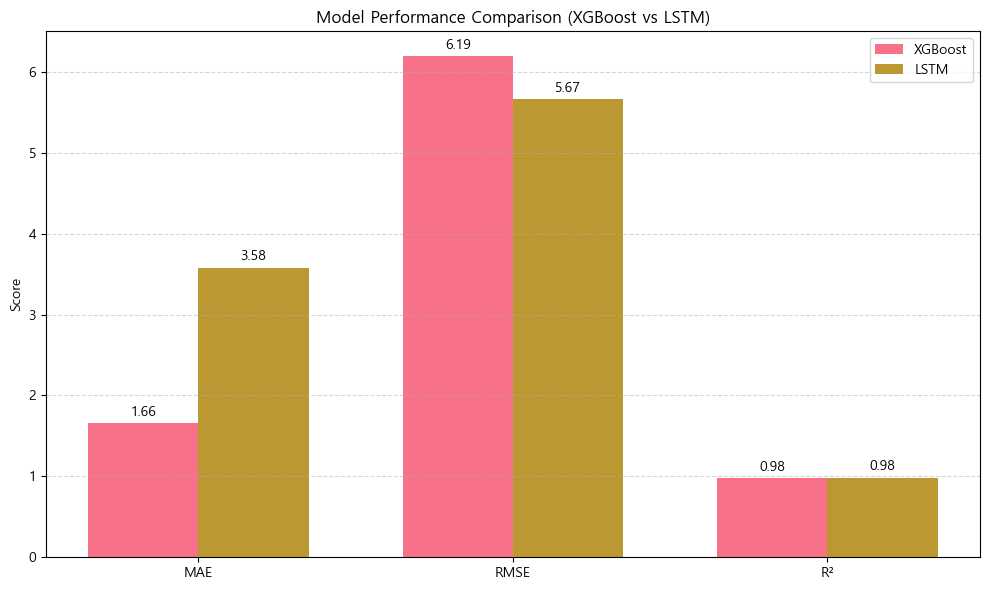

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ 각 모델별 성능 지표
models = ["XGBoost", "LSTM"]
mae_values = [mae_xgb_sentiment, mae_lstm]
rmse_values = [rmse_xgb_sentiment, rmse_lstm]
r2_values = [r2_xgb_sentiment, r2_lstm]

# 2️⃣ 📌 성능 수치 출력
# 성능 점수 저장
comparison_df = pd.DataFrame({
    "모델": ["XGBoost", "LSTM"],
    "MAE": [mae_xgb_sentiment, mae_lstm],
    "RMSE": [rmse_xgb_sentiment, rmse_lstm],
    "R²": [r2_xgb_sentiment, r2_lstm]
}).round(4)

# 성능 비교표 출력
print("\n📌 모델 성능 비교:")
print(comparison_df)

# 3️⃣ 시각화
labels = ["MAE", "RMSE", "R²"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [mae_values[0], rmse_values[0], r2_values[0]], width, label="XGBoost")
bars2 = ax.bar(x + width/2, [mae_values[1], rmse_values[1], r2_values[1]], width, label="LSTM")

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison (XGBoost vs LSTM)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(bars1, fmt="%.2f", padding=3)
ax.bar_label(bars2, fmt="%.2f", padding=3)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

# 이미지 저장
plt.savefig('./results/average_sentiment_comparison.png', dpi=300)

plt.show()

# 프로젝트 결론 및 인사이트

### 📈 주요 발견
- OpenAI 기반의 감성 분석 점수가 **테슬라 주가와 가장 높은 상관관계**를 보였습니다.
- KR-FinBERT는 중립적인 경향을 띄며, 국내 뉴스에는 안정적으로 작동하였습니다.
- VADER와 FinBERT의 평균값은 장기적 추세에는 의미 있으나, 예측에는 다소 둔감했습니다.
- LSTM 모델은 **단기적인 주가 방향을 예측하는 데 일정 수준의 가능성**을 보였습니다.

### 🛠️ 개선 및 다음 스텝
- 더 많은 뉴스 데이터 (예: 영문 뉴스, SNS 등) 수집 시 정확도 향상 가능
- Transformer 기반 시계열 모델(TCN, Temporal Fusion Transformer 등) 적용 시도
- 주가 외에도 거래량, 옵션 데이터 등을 feature로 확장 가능

# ✅ 프로젝트 결론 및 인사이트 요약

## 📊 주요 결과 정리

### 감성 점수 분포
- **OpenAI 감성 점수**
  - 부정(-1): **385건**
  - 중립(0): **485건**
  - 긍정(+1): **30건**
  - ➡ 뉴스 헤드라인의 감성은 **전반적으로 부정적** 경향이 강함

- **VADER/FinBERT 평균 점수**
  - -0.5: **471건**
  - 0.0: **429건**
  - ➡ 대부분의 뉴스가 중립 또는 부정으로 분류됨

- **KR-FinBERT 감성 분석**
  - 부정(-1): **261건**
  - 중립(0): **429건**
  - 긍정(+1): **210건**
  - ➡ 한국어 금융 뉴스에서는 **긍정 비중이 상대적으로 높음**

---

## 📈 시계열 분석 인사이트

- **2월 중순 ~ 3월 초**, OpenAI 감성 점수가 지속적으로 **-0.4 이하로 하락**  
  → 이와 유사한 시점에 **테슬라 주가가 $360 → $225로 급락**
- **OpenAI 감성 점수와 실제 주가의 방향성이 유사하게 움직임**
  → 뉴스 감성 점수가 **시장 심리 또는 투자자 반응을 일정 부분 반영**함을 시사

---

## 🤖 LSTM 예측 모델 성능 요약

- 입력 피처: 뉴스 감성 점수 (OpenAI, VADER/FinBERT, KR-FinBERT) + 기술적 지표
- 예측 대상: 테슬라 종가 (Close Price)
- 예측 성능:
  - 📌 **MAE (Mean Absolute Error)**: **3.5815**
  - 📌 **RMSE (Root Mean Squared Error)**: **5.6686**
  - 📌 **R² (결정계수)**: **0.9849**

→ 이는 모델이 전체 주가 변동의 약 **98.5%를 설명**할 수 있으며,  
단기 변동보다 **중기적인 추세 예측에 강점**이 있음을 시사

---

## 🧠 종합 결론

- OpenAI 기반 감성 분석 점수가 **주가 하락 구간을 가장 민감하게 반영**
- VADER/FinBERT는 보수적이며 안정적인 흐름을,  
  KR-FinBERT는 국내 뉴스에서의 긍정/부정 분류에 강점을 가짐
- 감성 분석을 수치화하여 LSTM에 입력한 전략은 **예측력 확보에 효과적**

---

## 🔧 향후 개선 방향

1. **뉴스 출처 다변화**: 영문 뉴스, 글로벌 이슈 반영 (ex: Reuters, Bloomberg)
2. **감성 점수 스무딩 처리**: 이동평균(SMA, EMA) 적용으로 노이즈 감소
3. **추가 피처 확장**:
   - 거래량(Volume), 옵션 데이터(Open Interest)
   - 특정 이슈(리콜, CEO 발언 등) 포함
4. **모델 개선 실험**:
   - Transformer 기반 시계열 모델(TFT, TCN)로 비교 실험
   - 하이퍼파라미터 튜닝 및 시계열 cross-validation 적용

---

📌 이번 프로젝트는 뉴스 데이터를 활용한 감성 분석 기반 주가 예측이  
**실제 시장 데이터와 통계적으로도 유의미한 연결이 있음을 보여준 사례**입니다.
